# DLTA Project Assignment II

---------------------
## Team information

|Team-number :| 15|
|:----:|:----:|


|       Name        |          E-Mail           | matriculation-nr. |
|:-----------------:|:-------------------------:|:-----------------:|
|    Fabian Dick    |  dick16@ads.uni-passau.de   |      104936      |
| Julian Dietlmeier | dietlm06@ads.uni-passau.de |       80363       |
|   Albert Nietz    |  nietz01@ads.uni-passau.de   |      103947      |

---------------------

## Introduction

Natural language processing (NLP) aims at systemizing information from text in the form of numerical representations. For this aim several methods exist. The following project assignment is about comparing different methods for textual representations which are then used for a binary classification of these texts.  The used dataset contains questions and answers from earning calls of listed companies, such as Meta or Starbucks. Earning calls have the potential to be an important source for stock market data predictions, since financial results, risks or specific outlooks of the underlying businesses are made. With the usage of NLP, earning calls can be analyzed efficiently by structuring the text into certain categories, such as open/specific questions or negative/positive answers. For further processes this information could be then used for opportunities or risk analytics regarding the company, which is not the aim of this work. However the questions comes up which NLP techniques should be applied for the best results and whether it makes any difference at all. To answer this research question the textual representation methods term-frequency inverse-document-frequency (tf-idf), latent semantic analysis (LSA), global vectors (GloVe) and Word to Vec (W2V) are used. The numerical output is then used for a supervised classification problem by applying a Neural-Network-Classifier and a Linear-Classifier, which is used as the baseline model, in the form of a logit regression.
In a first step each earning call is separated into questions and answers while in a second step each question and answer get a label. Although several other labels exist in the dataset, in this notebook we focus on the question labels "company_specific" and "market_related", since these labels might be the most important ones when it comes to predict stock market data either for the specific company or for the market in general.
We use each question of the earning calls as corpus and calculate their word embedding with different NLP methods. In addition, to overcome the unbalanced data set, we use oversampling methods. Finally the aim of this notebook is to evaluate different NLP strategies and classifiers based on the prediction performance measured by confusion matrices and receiver operating characteristic metrics. The results are shown in the way such that each NLP-classifier combination is presented individually in order to analyze the outcome per classifier as well as per textual representation technique. Following that, to directly compare the different classifier methods and in order to generalize the results, crossvalidation is used.

Please note that the following descriptions will focus on explaining the gist of the approach. In most cases they will not provide in-depth details about the implementation etc. Please see the comments in the source code for more details regarding the implementation.

In [ ]:
from math import floor, ceil


def prompt(message: str, formatter = 'plain', promt_length = 80):
    """
    Helper function which prints a formatted console messages.

    :param message: str message
    :param formatter: desired formatting
    :param promt_length: desired message length, default is 80 chars
    :return:
    """
    print(messageFormatter(message, promt_length))


def messageFormatter(message: str, prompt_length, fill_char ="-"):
    """Function which formats the input string"""
    message = " " + message.strip() + " "
    fill_length = (prompt_length - len(message)) / 2
    prefix = str(fill_char * floor(fill_length))
    postfix = str(fill_char * ceil(fill_length))
    return prefix + message + postfix + "\n"

Before the text import and preprocessing can be covered, a small convenience function has to be discussed. The ```prompt()``` function is used to print formatted console outputs. Usually this is used to give feedback about the current processing step or at the beginning of the execution of a command.

In [ ]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

Additionally a small helper function is used to display tables side by side, which is used in the result chapter. 

## Text Import and Preprocessing

### Text Import

In [ ]:
from label_studio_sdk import Client
from label_studio_sdk import project
import numpy as np
import pandas as pd
from os.path import exists
from collections.abc import Iterable


def DataImport(overwrite: bool = False) -> pd.DataFrame:
    """
    Wrapper function for data download and import. It checks if a *.csv file is present and handles the data download and data transformation if it's not.

    :param overwrite: Boolean value which determines if the available csv files would be overwritten by new ones (means DataDownload is used, even though the data is locally available)
    :return: DataFrame
    """
    if not exists("Data/all_data.csv") or overwrite:
        prompt("Starting data download")
        DataDownload()

    prompt("Starting data import")
    data = pd.read_csv("Data/all_data.csv", index_col = 0)
    return data


def DataDownload() -> pd.DataFrame:
    """
    Function which covers the data download and transformation. Therefore, the raw data is fetched from the server
    (requires VPN). Afterwards two helper functions are created, one which basically an element-wise application of
    str.contains to a list. The other helper function contains the logic required for the label selection if more
    (or less) than 4 labels are available for one text (=Question/Answer). Then a dictionary for the raw_data is created,
    which will contain a list for "strat"-, "end"-, "text"- and "label"-data. Then a for loop iterates through the raw
    data and appends the information to the respective lists.
    This results in a DataFrame which contains an entry for each label, or in other words for each question/answer in
    each doc (ideally) four entries with ID, and the three question/answer levels.
    Next step shall be combining the 4 stages of the labels together. This requires a matching of the text and/or
    start/end information. Because the text and/or start/end information for each label can not be directly matched
    (because sometimes there are additional characters included at the beginning or end of the text, therefore the stat
    and end information can also be different) a matrix with the absolute distances is calculated.
    Afterwards an uncertainty factor is set (to a distance of 10) and a list of all elements which have a distance of less
    than 10 to each other is created. This ensures that the entries which are the closest to each other are
    combined/matched. Now the label information of each stage can be combined. For that a for loop iterates through each
    "label-group" ("label-group" refers to the 3, 4 or 5 labels which are closest to each other) and selects the
    label-name to one of the for label-stages (QID/AID, label_l1, label_l2, label_l3). If more than 1 label is present
    for one label stage (for example if a question has two times question_3_* labels) in a first step the algorithm
    tries to use np.unique to see if the two question_3_* labels are actually different. If that's the case, one can just
    use one of the two labels without loss of information. If that's NOT the case, one has to choose to drop information
    (then only the FIRST of the two labels is used) or include the information (then an array of the two labels is used,
    which obviously breaks the unique labeling if each text).
    After four label stages are matched to the text, one obtains a DataFrame with one column for text and four columns
    for the label stages.
    This DataFrame is then saved as csv and can be loaded at a later point in time.

    :return: DataFrame
    """
    LABEL_STUDIO_URL = 'http://132.231.59.226:8080'  # this address needs to be the same as the address the label-studio is hosted on.
    API_KEY = '430d989b7f9723b1e5d82462ded8a22bfb331c6d'  # please add your personal API_Key here to get your API_Key follow the Pictures below

    ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)
    ls.check_connection()
    pro = project.Project.get_from_id(ls, "1")
    tasks = project.Project.get_labeled_tasks(pro)

    def arrayContains(x: Iterable, y:str) -> Iterable:
        """
        Checks of an (str) element of a list contains y

        :param x: List or iterable where each element is a str
        :param y: str
        :return: List of bools
        """
        output = []
        for a in x:
            output.append(str(a).__contains__(y))

        return output

    strange_list = pd.DataFrame(columns=['docID', 'start', 'end', 'text', 'label', 'id'])

    def selectLabel(array, label, first=True):
        """Algorithm which selects a label"""
        nonlocal strange_list
        label_array = list(array.loc[arrayContains(array['label'], label), 'label'])
        if len(label_array) == 1:
            return str(label_array[0])
        elif len(label_array) == 0:
            strange_list = strange_list.append(pd.DataFrame(array), ignore_index=True)
            return str(np.NAN)
        else:
            strange_list = strange_list.append(pd.DataFrame(array), ignore_index=True)
            if len(np.unique(label_array)) == 1:
                return str(np.unique(label_array)[0])
            elif first:
                return str(label_array[0])
            else:
                return str(label_array)

    mylen = np.vectorize(len)

    data_all_raw = {}
    data_all_raw['docID'] = []
    data_all_raw['start'] = []
    data_all_raw['end'] = []
    data_all_raw['text'] = []
    data_all_raw['label_id'] = []
    data_all_raw['label_l1'] = []
    data_all_raw['label_l2'] = []
    data_all_raw['label_l3'] = []

    for t in range(0, len(tasks)):
        # Acquire Raw Data
        data_raw = {}
        data_raw['docID'] = []
        data_raw['start'] = []
        data_raw['end'] = []
        data_raw['text'] = []
        data_raw['label'] = []

        for e in tasks[t]['annotations'][0]['result']:
            data_raw['docID'].append(tasks[t]['id'])
            data_raw['start'].append(e['value']['start'])
            data_raw['end'].append(e['value']['end'])
            data_raw['text'].append(e['value']['text'])
            data_raw['label'].append(e['value']['labels'][0])

        data = pd.DataFrame(data_raw)
        data['id'] = list(range(0, data.shape[0]))

        # Create distance Matrix
        start_vec = np.array(data['start']).reshape((-1, 1))
        helper = np.ones(len(start_vec)).reshape((1, -1))

        A = np.matmul(start_vec, helper)

        dist = A - A.T

        # Create Groups which are most similar to each other
        uncert = 10
        grouping_vec = list()
        for i in range(0, dist.shape[0]):
            helper = list()
            for j in range(0, dist.shape[0]):
                if abs(dist[i][j]) < uncert: helper.append(j)
            grouping_vec.append(helper)

        grouping_vec = [list(x) for x in set(tuple(x) for x in grouping_vec)]

        # Create dic with the values
        for e in grouping_vec:
            helper = data.loc[e, :]
            data_all_raw['docID'].append(tasks[t]['id'])
            data_all_raw['start'].append(helper['start'].min())
            data_all_raw['end'].append(helper['start'].max())
            data_all_raw['text'].append(
                str(list(helper.loc[mylen(helper['text']) == mylen(helper['text']).max(), 'text'])[0]))
            data_all_raw['label_id'].append(selectLabel(helper, "ID"))
            data_all_raw['label_l1'].append(selectLabel(helper, "_1_"))
            data_all_raw['label_l2'].append(selectLabel(helper, "_2_"))
            data_all_raw['label_l3'].append(selectLabel(helper, "_3_"))

    data_all = pd.DataFrame(data_all_raw)
    strange_list = pd.DataFrame(strange_list)

    data_all.to_csv("Data/all_data.csv")
    data_all.to_excel("Data/all_data.xlsx")
    strange_list.to_csv("Data/strange_list.csv")
    strange_list.to_excel("Data/strange_list.xlsx")

Prior to the important step of data preprocessing, the data must be downloaded and imported. This is handled by the ``` DataImport()``` function. First, it checks if a data save file exists and imports it into a data-frame. If that’s not the case (or the overwrite parameter is set to ```True```), the function will download the data and trigger a first step of pre-transformation of the data. 

This is done in the ```DataDownload()``` function. It downloads the data, which comes as a nested object (meaning object which contains many sub- and sub-sub-objects). The aim of the data pre-transformation is therefore the extraction of the relevant information from the downloaded data and representing as a convenient data-frame. In a first step the document ID, start and end as well as the text and label of each annotation in each document are saved in a list and then transformed to a data-frame. Annotation refers in this context to an individual label. Additionally, it is known that each text passage has to have four annotations. The question or answer ID as well as the label stage one to three. Therefore, the data-frame construction yields a “long” representation of the label data, meaning that each text passage occurs four times, one time for each label stage. 

The next step is therefore the transformation of this “long” representation into a “wide” representation, where for each text passage one row exists, and the four label stages are saved in four columns. Because of labeling errors, the text passages can contain additional characters at the beginning or end of the passage. Therefore, matching the text passages is not trivial. An easy solution is the calculation of absolute distances between the start points of each text passage and then grouping all text passages together which have a distance of less than 10 for example. In most cases this yields a list of four labels which belong to the same text passage. With regex matching the ID label and label stages can then be obtained and saved in the columns of a new data-frame. However, in some cases there are more or less labels than four for one text passage. In this case the ``` selectLabel()``` sub-function automatically applies two strategies to resolve this issue. If there are less than four labels, the missing labels are set to NA. If there are more than four labels, it will apply ```np.unique()``` which could lead to a reduction of labels if one label is used multiple times on the same text passage. Otherwise, if this does not lead to a reduction of labels it will list all labels for the current label-stage and select the first label in the list of multiple labels of the respective label stage. This leads to data loss, because the other labels can not be taken into account. However, it is impossible to identify the "correct" label without manual intervention. In order to give better insight into these non-standard situations and keep a protocol, the current label list is saved in a separate list called ```strange_list```. 

After this step is finished, the “wide” representation data-frame is saved as csv and the ```DataImport()``` function can proceed to import the now downloaded and pre-transformed data.

### Text Preprocessing and Processing

In [ ]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import SpaceTokenizer
from nltk.stem import WordNetLemmatizer
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN


def dataCheck(data: pd.DataFrame, keepNA: bool = False, keepOldIDs: bool = False) -> pd.DataFrame:
    """
    Checks the data for missing values (na) and (optionally) removes them.

    :param data: data object (pd.DataFrame)
    :param keepNA: the rows containing nas are not dropped, the function then only returns the na count per column and number or rows containing at least one na
    :param keepOldIDs: the pd.dropna function drops the rows containing nas, but does not change the indexing, which leads to missing index values. Therefore, for loops iterating over row-indices will not work anymore. Therefore, the index is replaces by a new index. If the old index is import it can be saved as column of the DataFrame
    :return: DataFrame
    """
    print(data.isna().sum())

    rowwiseIsNA = np.vectorize(pd.isna)
    rowwiseNA = rowwiseIsNA(data)
    numRemovedRows = sum([any(row) for row in rowwiseNA])
    prompt(f"There will be {numRemovedRows} rows removed")

    if not keepNA:
        data = data.dropna(axis = 0)
        data = data.reset_index(drop=not keepOldIDs)

    return data


def textPreprocessing(data: pd.DataFrame, input_col: str = 'text', keepSteps: bool = True, keepOriginalData: bool = True) -> pd.DataFrame:
    """
    Wrapper function for the text preprocessing. Applies the following text preprocessing steps:
        1) removes capitalisation (output column of this step: 'proText_C')
        2) removes punctuation (output column of this step: 'proText_CP')
        3) removes stopwords (output column of this step: 'proText_CPS')
        4) Lemmitazation (stemming) of the tokens (output column of this step: 'proText_CPSL')

    :param data: data object (pd.DataFrame)
    :param input_col: name of the column containing the original text
    :param keepSteps: Boolean-Value which determines if the columns which results after each of the four steps are dropped or kept
    :param keepOriginalData: Boolean-Value which determines if the original text data is saved or not
    :return: Data Frame
    """
    data = textCapitalisation(data)
    data = textRmPunctuation(data)
    data = textRmStopwords(data)
    data = textLemmatization(data)

    data[str(str(input_col) + "_original")] = data[input_col]
    data[input_col] = data['proText_CPSL']

    if not keepSteps:
        data = data.drop(['proText_C', 'proText_CP', 'proText_CPS', 'proText_CPSL'], axis = 1)

    if not keepOriginalData:
        data = data.drop([str(str(input_col) + "_original")], axis = 1)

    return data


def textCapitalisation(data: pd.DataFrame, input_col: str = 'text', output_col: str ='proText_C') -> pd.DataFrame:
    """
    Function which covers the removal of the capitalisation. Therefore, the np.vectorize function is used to create a new
    function which returns an array of strings. Each element in this array of strings is created from one element of the
    text column to which the str.lower function is applied. This procedure basically leads to an elementwise application
    of the str.lower function. The results are then saved in a new column.

    :param data: Data object (pd.DataFrame)
    :param input_col: Name of the column containing the strings of the previous step.
    :param output_col: Name of the column which will contain the texts after the application of the current step/transformation.
    :return: DataFrame which includes a text colum where the punctuation was removed
    """
    prompt("Starting removal of capitalization")
    rmCap = np.vectorize(str.lower)
    data[output_col] = rmCap(data[input_col])

    return data


def textRmPunctuation(data: pd.DataFrame, input_col: str = 'proText_C', output_col: str = 'proText_CP') -> pd.DataFrame:
    """
    Function which covers the removal of punctuation. Therefore, the punctuation, digits from the strings library and some
    costume strings are used. With the help of the maketrans and translate function each punctuation and digit character
    is removed (or rather replaced by '') in each text. Additionally, double spaces are replaced, which could result from
    the removal of punctuation (e.x. "We spend 100$ on xy." => "We spend  on xy"). Afterwards leading and trailing
    spaces are removed from the texts.

    :param data: Data object (pd.DataFrame)
    :param input_col: Name of the column containing the strings of the previous step
    :param output_col: Name of the column which will contain the texts after the application of the current step/transformation.
    :return: DataFrame which includes a text colum where the punctuation was removed
    """
    prompt("Starting removal of punctuation")
    for s in range(data.shape[0]):
        data.loc[s, output_col] = data.loc[s, input_col].translate(str.maketrans({".": ". ", ",": ", ", "?": "? ", "!": "! "}))
        data.loc[s, output_col] = data.loc[s, output_col].translate(
            str.maketrans('', '', string.punctuation + string.digits + "–" + "‘"))  # .replace("'", "")

        data.loc[s, output_col] = str(data.loc[s, output_col]).replace('      ', ' ')
        data.loc[s, output_col] = str(data.loc[s, output_col]).replace('     ', ' ')
        data.loc[s, output_col] = str(data.loc[s, output_col]).replace('    ', ' ')
        data.loc[s, output_col] = str(data.loc[s, output_col]).replace('   ', ' ')
        data.loc[s, output_col] = str(data.loc[s, output_col]).replace('  ', ' ')

    rmLeadSpace = np.vectorize(str.lstrip)
    data[output_col] = rmLeadSpace(data[output_col])

    return data


def textRmStopwords(data: pd.DataFrame, input_col ='proText_CP', output_col ='proText_CPS') -> pd.DataFrame:
    """
    Function which covers the removal of stopwords. For that the nltk packages is used which contains a list
    of common (english) stopwords. To this list were some obviously missing words added. Because of the previous step,
    the stopwords have to be stripped of their punctuation. Then each string element is seperated into its tokens and all
    tokens which are in the list of stopwords are removed. Afterwards a new string is created. The results have shown
    that some special characters where not removed correctly, therefore the punctuation is removed again.
    After that the resulting word list and word frequency's in the corpus where analysed (upper 5% of word frequencies)
    and a list of additional stopwords (with high frequencies) was created, which are then removed separately.

    :param data: Data object (pd.DataFrame)
    :param input_col: Name of the column containing the strings of the previous step.
    :param output_col: Name of the column which will contain the texts after the application of the current step/transformation.
    :return: DataFrame which includes a text colum where the stopwords were removed
     """
    prompt("Starting removal of stopwords")
    nltk.download('stopwords')
    nltk.download('punkt')

    all_stopwords = stopwords.words('english')
    all_stopwords.extend(["i'm", "it'll"])

    all_stopwords_noPunc = []
    for word in all_stopwords:
        all_stopwords_noPunc.append(word.translate(str.maketrans('', '', string.punctuation + string.digits + "–")))

    all_stopwords.extend(all_stopwords_noPunc)

    tk = SpaceTokenizer()

    for s in range(data.shape[0]):
        tokens = tk.tokenize(data.loc[s, input_col])
        tokens_noStop = [word for word in tokens if not word in all_stopwords]
        data.loc[s, output_col] = (" ").join(tokens_noStop)
        data.loc[s, output_col] = data.loc[s, output_col].translate(
            str.maketrans('', '', string.punctuation + string.digits + "’"))
        data.loc[s, output_col] = str(data.loc[s, output_col]).replace('  ', ' ')

    additional_stopwords = ["were", "us", "going", "thats", "well", "weve", "one", "also", "q", "–", "still", "its",
                            "g", "theyre", "may", "ill", "id", "dont", "ive", "cant", "theyve", "im", "youre", "hi"]

    for s in range(data.shape[0]):
        tokens = tk.tokenize(data.loc[s, output_col])
        tokens_noStop = [word for word in tokens if not word in additional_stopwords]
        data.loc[s, output_col] = (" ").join(tokens_noStop)

    return data


def textLemmatization(data: pd.DataFrame, input_col: str ='proText_CPS', output_col: str ='proText_CPSL') -> pd.DataFrame:
    """
    Function which covers lemmatization. Again the nltk packages is used here. Each element in the text columns is again
    seperated into its tokens and then the stem of the corresponding token is returned and combined back to a string.

    :param data: Data object (pd.DataFrame)
    :param input_col: Name of the column containing the strings of the previous step.
    :param output_col: Name of the column which will contain the texts after the application of the current step/transformation.
    :return: DataFrame which includes a text colum where the stemming was done
    """
    prompt("Starting lemmatization")
    nltk.download('wordnet')
    nltk.download('omw-1.4')

    tk = SpaceTokenizer()
    lemmatizer = WordNetLemmatizer()

    for s in range(data.shape[0]):
        tokens = tk.tokenize(data.loc[s, input_col])
        data.loc[s, output_col] = (" ").join([lemmatizer.lemmatize(w) for w in tokens])

    return data


def dataSelection(data: pd.DataFrame, label_stage: int, doc_type: str = 'question'):
    """
    Function which handles the filtering of the data.

    :param data: DataFrame of the data
    :param label_stage: Integer value of the label stage (range from 1 to 3)
    :param doc_type: Type of the document (range 'question', 'answer')
    :return: returns a DataFrame with the filtered data
    """
    label_stage_str = f"label_l{label_stage}"
    type = {'question': 'QID', 'answer': 'AID'}
    type_label = {'question': 'Question', 'answer': 'Answer'}
    label_str = f"{type_label[doc_type]}_{label_stage}"

    selection_id = data['label_id'].str.contains(type[doc_type])
    selection_label = data[label_stage_str].str.contains(label_str)

    return data.loc[[x&y for x, y in zip(selection_id, selection_label)], :]


def dataSample(documentRep: pd.DataFrame, data: pd.DataFrame, method: str, n: int, col: str = 'label_l1', folds = 10) -> pd.DataFrame:
    """
    Handles the data sampling.

    :param documentRep: Document representation
    :param data: dataset
    :param method: method of sampling ('undersample', 'resample')
    :param n: desired length of sampled data (obsolete for undersampling because the number of samples of the smallest group is set as n)
    :param col: name of the target column
    :param folds: Number of folds the data should be devided in. The fold number is determined by "sample draw without replacement" and is added as integer column to the resulting dataframe
    :return: DataFrame of document representation in 'doc'-column and labels in 'labels'-column and the fold number in the 'fold'-column
    """
    labels = np.unique(data[col])
    label_counts = {}
    for l in labels:
        label_counts[l] = label_counts[l] = data[col].str.cat(sep = " ").split().count(str(l))

    data_groups = {}
    for l in labels:
        data_groups[l] = data.loc[data[col] == l, :].index

    vectors = []
    categories = []
    if method == "undersample":
        n = min(label_counts.values())
        for l in labels:
            vectors.extend(documentRep.loc[np.random.choice(data_groups[l], n, replace=True), :])
            categories.extend(data.loc[np.random.choice(data_groups[l], n, replace=True), col])

    elif method == "resample":
        for l in labels:
            vectors.extend(documentRep.loc[np.random.choice(data_groups[l], n, replace = True), :] )
            categories.extend(data.loc[np.random.choice(data_groups[l], n, replace = True), col] )

    elif method == 'random':
        oversampler = RandomOverSampler(random_state = 42)
        vectors, categories = oversampler.fit_resample(documentRep, data[col])

    elif method == 'SMOTE':
        oversampler = SMOTE(random_state = 42)
        vectors, categories = oversampler.fit_resample(documentRep, data[col])

    elif method == 'BorderlineSMOTE':
        oversampler = BorderlineSMOTE(random_state = 42)
        vectors, categories = oversampler.fit_resample(documentRep, data[col])

    data_sample = pd.DataFrame()
    n = len(categories)
    fold_n = int(np.ceil(n / folds))
    fold_vec = np.array([i+1 for i in range(folds)] * fold_n)
    data_sample['doc'] = vectors.to_numpy().tolist()
    data_sample['labels'] = categories
    data_sample['fold'] = np.random.choice(fold_vec, n, replace = False)

    return data_sample


def dataSplit(data: pd.DataFrame, test_fold = 10):
    """
    Handles the splitting of data (data and document representation that is, every data as long the row-index matches the doc-index)

    :param data: DataFrame of data
    :param test_fold: number of the fold, that should be used for the test data
    :return: tuple of train and test data
    """
    data = data.sample(frac=1)

    #split_index = np.quantile(data.index, train_split_frac) # np.floor(train_split_frac * data.shape[0])
    dataTrain, dataTest = data.loc[data['fold'] != test_fold, :], data.loc[data['fold'] == test_fold, :]
    return dataTrain, dataTest


def generateEncodingMatrix(data: pd.Series) -> pd.DataFrame:
    """
    Generates a DataFrame which holds a 'index' column (number) and a 'value' column (labels). Each column can be set as index and therefore a translation between labels and number representation is possible.

    :param data: Series of labels
    :return: DataFrame
    """
    labels = np.unique(data)
    encoding_matrix = pd.DataFrame([[i, v] for i, v in enumerate(labels)], columns=['index', 'value'])
    return encoding_matrix


def dataEncoding(data: pd.Series, encoding_matrix: pd.DataFrame):
    """
    Handles the encoding (translation from text labels to number representation) of the labels.

    :param data: Series of (text) labels
    :param encoding_matrix: encoding_matrix (see generateEncodingMatrix)
    :return: array of encoded data
    """
    return encoding_matrix.set_index('value').loc[data, 'index'].values


def dataDecoder(data, encoding_matrix):
    """
    Handles the decoding (translation from number representation labels to text labels) of the labels.

    :param data: array/Series of numbers
    :param encoding_matrix: encoding_matrix (see generateEncodingMatrix)
    :return: array of decoded data
    """
    return encoding_matrix.set_index('index').loc[data, 'value'].values

Not all functions shown in this section are directly related to text preprocessing. Some of them also handle data processing, data sampling, text en- and decoding etc. and are therefore relevant at different points in the estimation timeline. The functions will thus be covered in a chronological fashion which is loosely related to their application in the whole data-pipeline. Starting with ```dataCheck()```. This function checks for missing values resulting from the data pre-transformation, calculates the number of rows which will be lost if every row with at least one NA is removed and optionally removes these rows (it can therefore also be used for so-called “dry-runs”). 
Next the ```textPreprocessing()``` function handles the text preprocessing, which includes:

1. Removal of capitalization in ```textCapitalisation()```
2. Removal of punctuation in ```textRmPunctuation()```
3. Removal of stopwords in ```textRmStopwords()```
4. Stemming in ```textLemmatization()```

These steps are very well known, and their implementation is rather standard. ```textCapitalisation()``` uses a vectorized version of the ```str.lower()``` function to the vector of texts to remove the capitalization. ```textRmPunctuation()``` maps punctuation characters to punctuation character plus space (this has to be done because the DIN-norm is not strictly followed, where each “.”, “?”, “!”, “,” etc. has to be followed by a space. For example, in the text: ```Hello.World``` the removal of the “.” would lead to false word ```HelloWorld``` instead of two words ```Hello World```). Afterwards each character from ```string.punctuation``` is removed and multiple spaces following each other are also removed. Additionally, each text is trimmed, which means that leading and trailing spaces are removed from the text. ```textRmStopwords()``` takes a standard list of common stop words, provided by the nltk package and removes them from the word-list. In addition to that, the 5% most common words in this corpus where listed and a manually curated list of stop words is created and removed from the word-list. Last but not least, ```textLemmatization()``` then uses the nltk package again for the stemming step. Each word is thereby replaced by its stem-word.

After the text-preprocessing, the next step in the data timeline, is the data selection, handled by the ```dataSelection()``` function. It takes as parameters the desired label stage and doc type (question or answer). With this information it is then possible to filter the data for a certain label stage. Next, the ```dataSample()``` function handles the sampling of the data. This is required because the groups in the selected label stage are unbalanced. The data sampling therefore uses one of multiple methods to construct a dataset with balanced groups. There are different sampling methods possible:

* Undersampling: A random subset of the larger group is used, such that the groups have equal sizes.
* Resampling: Bootstrapping-like approach where random draws from the underrepresented group are added until all groups are of equal size.
* Oversampling: With methods like “SMOTE” or “BorderlineSMOTE” new observations for the underrepresented group are generated until all groups have the same size.

Additionally, this function adds a column which holds the fold this observation belongs to. This is later used for splitting in train and test data and for cross-validating the methods.
For the splitting of the data, the ```dataSplit()``` function is used. It selects a certain fold which is returned as test data.
Lastly, there are three functions for encoding the labeled data. This means they handle the translation between labels and numerical representation of their labels. The ```generateEncodingMatrix()``` uses the unique labels in data to generate a data-frame where each label is matched to a unique number. The ```dataEncoding()``` function uses the encoding matrix and the labeled data to generate a vector with the numerical representation and the ```dataDecoding()``` function reverses this process.

## Performance Evaluation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pylab as plt


def calculateConfusionMatrix(data_true: pd.Series, data_pred: pd.Series, freq: bool = True) -> pd.DataFrame:
    """
    Wrapper function for sklearn.metrics.confusion_matrix. It can additionally handle frequency representation of the confusion matrix.

    :param data_true: Series of the true data
    :param data_pred: Series of predicted data
    :param freq: Boolean which determines if the returned confusion matrix should be in absolut values or frequency representation
    :return: DataFrame of confusion matrix
    """
    labels = np.unique(data_true)
    con = confusion_matrix(data_true, data_pred, labels=labels)
    if freq:
        con = con / con.flatten().sum()

    con = pd.DataFrame(con, columns=["pred " + x for x in labels], index=labels)
    return con


def roc_measure(data: pd.DataFrame, encoding_matrix: pd.DataFrame, label_true: str, label_prob: str, plot_title: str, plot: bool = True):
    '''
    Function which handles the plot of the ROC curve as well as calculating and returning the area under the curve.

    :param data: pd.DataFrame with all the data, but has to contain on column with the true labels and one column with the predicted probabilities
    :param encoding_matrix: encoding matrix
    :param label_true: Name of the column which contains the true labels
    :param label_prob: Name of the colum which contains the predicted probabilities
    :param plot_title: Title of the ROC plot
    :param plot: boolean if a plot should be generated or not
    :return: ROC curve and AUC metric
    '''
    data_true = data[label_true]
    prop_pred = data[label_prob]

    #binarize the data
    y_coi = []

    for label in range(data_true.shape[0]):
        y = int(data_true.iloc[label] == encoding_matrix.set_index('index').loc[1, 'value'])
        y_coi.append(y)

    #calculate ROC and AUC measures
    fpr, tpr, _ = roc_curve(y_true = y_coi, y_score = prop_pred)
    area_under_curve = roc_auc_score(y_coi, prop_pred)

    if plot:
        #plot ROC curve
        plt.figure()
        lw = 2
        plt.plot(
            fpr,
            tpr,
            lw = lw
        )
        plt.plot([0, max(fpr)], [0, max(tpr)], color="black", lw=lw, linestyle="--")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{plot_title}')
        plt.show()

    return area_under_curve

In order to evaluate the performances across the word-embedding-classification combinations different metrics are implemented and explained in the following.


The performance measures are based on the ability to look at a certain probability threshold more closely and to obtain results along the whole probability distribution of the results. The threshold determines the limit of the predicted probabilities from when a label is assigned to the category 1 (determined by one-hot-encoding in the ```generateEncodingMatrix()```), in our case "Question_1_Company_specific". Additionally metrics such as accuracy are conceivable but not applied for the sake of clarity.

Therefore, the performance measures are the following:
-	Confusion matrices
-	Receiver operating characteristics (ROC)  
-	Area under curve (AUC)

**Confusion matrices**

The confusion matrix generation is implemented in the function ```calculateConfusionMatrix()``` and represents a wrapper function of the ```confusion_matrix()``` function from the sklearn library. The parameters used for the calculation are the actual underlying labels (data_true) and the predicted labels (data_pred). The input of the matrix is the classical positive (correctly specified labels “Question_1_Company_specific” and “Question_1_Market_related”) and negative (wrongly specified labels “Question_1_Company_specific” and “Question_1_Market_related”) measures. Then the confusion matrix can be seen as follows:



|              |          pred Question_1_Company_specific           | pred Question_1_Market_related |
|:-----------------:|:-------------------------:|:-----------------:|
|     **Question_1_Company_specific**    |  $tp_{classifier}$   |      $fp_{classifier}$      |
|     **Question_1_Market_related**    |  $fn_{classifier}$   |      $tn_{classifier}$     

While tp stands for the true positives, fp for the false positives, fn for false negatives and tn for the true negatives.

Additionally, the function allows a frequency-based representation of the results via the parameter “freq”. By default, the parameter is set to true. Then the entries of the confusion matrix are calculated by dividing the absolute frequencies of each of the four fields by the number of documents. This frequency representation becomes important given the fact that the category "Question_1_Market_related" is underrepresented, since 70% of the labels are "Question_1_Company_specific". 


**ROC (curve) and AUC**

The ROC and AUC measures are calculated via ```roc_measure()```. The parameters are the dataset (```data```), the probability predictions (```prop_pred```) and an encoding matrix, created via the function ```generateEncodingMatrix()```, which is one-hot-encoding the labels (“Question_1_Company_specific”, “Question_1_Market_related”) into (1,0). This also requires the binarization of the true underlying labels in the dataset. Therefore, a list item ```y_coi``` (category of interest) is created , which is filled via a for loop which in turn appends 1 if the label is equal to “Question_1_Company_specific” and 0 otherwise. The next part of the function is about calculating the true positive rate (tpr) and the false positive rate (fpr) per probability by passing the list item ```y_coi``` and the probability predictions of the classifier into the function ```roc_curve()```.  The tpr and fpr are calculated as follows:

$$tpr = \frac{tp}{tp + fn} \quad ,$$

$$fpr = \frac{fp}{tn + fp}$$

To gain a broader view about the tpr vs. fpr distribution along the probability thresholds a plot is created which is typically called the “ROC-curve”. The plot shows the trade-off between correctly specified labels (“Question_1_Company_specific” predicted as “Question_1_Company_specific”), determined by the encoding matrix, and wrongly specified labels (e.g. “Question_1_Company_specific” predicted as “Question_1_Market_related”). The closer the curve is able to reach the coordinates (0,1) the better the results are. Further a random classifier is implemented in the form of a 45° line which originates in (0,0). 

Additionally, the AUC is calculated via the ```roc_auc_score()``` with the same parameters, while both functions are obtained by the sklearn library.  Then the AUC can be understood as the area under the roc curve and therefore the closer the number is to 1 the better are the results again. 




## Word Embedding Methods

### Term-frequency inverse-document-frequency (tf-idf)

In [ ]:
from collections.abc import Iterable
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def tf_idf(corpus: Iterable):
    """
    Function which generates a tf-idf representation of the corpus.

    :param corpus: Iterable/list/array or pd.Series which holds the document-texts
    :return: tf-idf matrix as dataframe
    """

    prompt("Starting TfIdf algorithm")
    tfidf_vec = TfidfVectorizer()
    tfidf = tfidf_vec.fit_transform(corpus)

    mat_tfidf = tfidf.toarray()
    df_tfidf = pd.DataFrame(data=mat_tfidf, columns=tfidf_vec.get_feature_names(), index=corpus.index)

    return mat_tfidf, df_tfidf

Having introduced the data processing, we will now discuss the selected methods that mathematically represent the words in the documents in different ways. A simple and at the same time frequently used method for converting text into a numerical form is the term-frequency inverse-document-frequency, tf-idf for short. The two terms "term-frequency" and "inverse-document-frequency" stand for two metrics that are multiplied together to determine a value for each word in a document: Both measures are briefly explained below.

* **Term-frequency:** As the name suggests, this metric represents the frequency of a word in a given document. There are several ways to calculate this frequency, but the easiest is to count the occurrences of a word in a document.
* **Inverse-document-frequency:** This metric indicates how frequent or rare a word is in the total number of documents. Mathematically, this frequency can be calculated by dividing the total number of documents by the number of documents containing the respective word and calculating the logarithm of this.

If a word occurs very frequently in a document and is also found in many other documents, the tf-idf score approaches 0, otherwise it approaches 1. Thus, a high score indicates a high relevance of a word in a document. After tf-idf has been described in general terms, the next section deals with the concrete implementation of this word embedding technique, which can be seen above.

The only argument that the function ```tf_idf()``` requires is the set of documents, also called corpus. Looking at the body of the function, the first thing to notice is that the tf-idf vectorizer is initialised from the well-known scikit-learn library. Due to the fact that the data has already been preprocessed, it is not necessary to set arguments such as ```stop_words``` or ```lowercase``` at this point. In the following step, the passed corpus is fed into the function ```fit_transform()``` to get the document-term matrix with the respective tf-idf scores as output. Afterwards, this output is converted into an array and a data-frame is created. At the end of the function, both are returned.


### Latent Semantic Analysis (LSA)

In [ ]:
from collections.abc import Iterable
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import pandas as pd


def LSA(corpus: Iterable, input_mat: Iterable):
    """
    Function which generates a LSA representation of the corpus.

    :param corpus: Iterable/list/array or pd.Series which holds the tf-idf matrix
    :param input_mat: word-document matrix
    :return: LSA matrix
    """

    prompt("Starting LSA algorithm")
    numb_topics = getNumbTopics(input_mat)

    lsa_model = TruncatedSVD(n_components=numb_topics, algorithm='arpack')

    mat_lsa = lsa_model.fit_transform(input_mat)
    df_lsa = pd.DataFrame(data=mat_lsa, index=corpus.index)

    return df_lsa


def getNumbTopics(input_mat: Iterable) -> int:
    """
    Function which determines the appropriate number of components.

    :param input_mat: Iterable/list/array or pd.Series which holds the tf-idf matrix
    :return: Number of components
    """

    list_var_explained = []
    numb_topics = 0
    flag = True
    steps = [50, 100, 250, 500, 800, 1000, 1200]

    for n in steps:

        lsa_model = TruncatedSVD(n_components=n, algorithm='arpack')
        doc_mat_lsa = lsa_model.fit(input_mat)
        list_var_explained.append(doc_mat_lsa.explained_variance_ratio_.sum())

        if(doc_mat_lsa.explained_variance_ratio_.sum() >= 0.7 and flag):
            flag = False
            numb_topics = n

    plotExplainedVariance(steps, list_var_explained)

    return numb_topics


def plotExplainedVariance(steps, list_variance_explained):
    """
    Function which plots the explained variance by n-components.

    :param steps: List which holds different amounts of topics
    :param list_variance_explained: List which holds the different explained variances
    """

    plt.plot(steps, list_variance_explained)
    plt.axhline(y=0.7, color='g', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel("Explained Variance")
    plt.title("Explained Variance by n-components")
    plt.show()

The tf-idf matrix from above has two statistically unfavourable properties: On the one hand, it suffers from high dimensionality and, on the other hand, it is very sparse, i.e. a large part of the entries are zeros. To overcome this problem, Latent Semantic Analysis (LSA), also known as Latent Semantic Indexing (LSI), is applied in this project assignment. The heart of LSA is singular value decomposition (SVD), an advanced matrix algebra method for matrix factorization. SVD ensures that the original document-term matrix with dimensions (*n* x *d*) can be approximated by a new matrix with dimensions (*n* x *k*), where *k* < *d* holds. If the additional condition *k* < min{*n*, *d*} is given, which means that k is smaller than the number of documents and words in the data, the approach is called truncated SVD. Each row of the new matrix represents a document and each column a so-called topic (or component). Therefore, LSA falls under the category of topic models, where, as the name already suggests, it is assumed that each document can be described with a mixture of different topics. Finally, it is important to mention that these topics are latent variables, which means that they are unobservable and usually difficult to interpret.

Turning to the implementation of the function ```LSA()```, it is noticeable that in addition to the corpus, an input matrix is also passed, which corresponds to the tf-idf text representation returned by function ```tfidf()``` described in the previous chapter. Due to the fact that the number of topics is not determined automatically, the auxiliary function ```getNumbTopics()``` is called first and takes the input matrix as argument. Within this auxiliary function, the matrix factorization takes place by using truncated SVD from the scikit-learn library, considering different topic sizes (50, 100, 250, etc.). Finally, the smallest topic size that allows to explain 70% or more of the variance of the original document-term matrix will be returned. Additionally, the auxiliary function ```plotExplainedVariance()``` generates a plot that gives an overview of the explained variance per topic size. The next step is to create an instance of the truncated SVD within the function ```LSA()```. Beside the number of topics the SVD solver "arpack" is set, which is the same as in the SciPy library (scipy.sparse.linalg.svds)  known from the lecture. Afterwards the truncated singular value decomposition is applied to the input matrix by calling the function ```fit_transform()```. This produces a new matrix, which has a lower dimensionality and contains latent topics as columns. Subsequently, a data-frame is generated from it, which is returned at the end of the function.

### Global Vectors (GloVe)

In [ ]:
import numpy as np
import itertools
from collections.abc import Iterable
import pandas as pd
from tqdm import tqdm
from os.path import exists
import matplotlib.pylab as plt


def generateContextDic(corpus: Iterable, window: int = 5) -> dict:
    """
    Generates a dictionary which holds an array with all context words of every word in the vocabulary

    :param corpus: List or array (or pd.Series) of documents (text entries)
    :param window: The context window size (symmetrically around i)
    :return: Dictionary of word (key) and context-word-arrays (values)
    """
    context_dic = {}
    vocab = pd.Series(corpus).str.cat(sep = " ").split()
    vocab = np.unique(vocab)

    for word in vocab:
        context_dic.setdefault(word, [])

    for entry in corpus:
        tokens = [np.NAN for i in range(window)] + entry.split() + [np.NAN for i in range(window)]
        for i in range(window, len(tokens)-window):
            scope = tokens[(i-window):(i+window+1)]
            context_dic[scope.pop(window)].extend(scope)

    return context_dic


def generateCoOccurrenceMatrix(context_dic: dict):
    """
    Function which generates the Co-Occurence-Matrix. It takes a context dictionary as input and then counts the words
    in the context dictionary for each key-value pair.
    Additionally, saves the resulting matrix as csv.

    :param context_dic: Dictionary with the word context-array pairs.
    :return: Matrix of the co-occurences
    """
    vocab = context_dic.keys()
    matrix = pd.DataFrame(np.zeros((len(vocab), len(vocab)), np.float64), index=vocab, columns=vocab)

    for word in tqdm(vocab):
        scope = pd.Series(context_dic[word]).dropna().str.cat(sep = " ").split()
        unique_terms = np.unique(scope)
        for term in unique_terms:
            matrix.loc[word, term] = scope.count(term)
    matrix.to_csv("Data/GloVe_CoOcMatrix.csv")
    return matrix


def GloVe(corpus: Iterable, overwrite: bool = False, eta: float = 0.00001, eta_bias: float = 0.00002, epochs: int = 20, set_seed: int = None, use_weights: bool = False, x_max = 100, alpha = 3/4, word_embedding_dim = 300):
    """
    Function which handles the GloVe fitting.

    :param corpus: Iterable/list/array or pd.Series which holds the document-texts
    :param overwrite: Boolean which determines if the co-occurrence matrix is re-calculated and the old csv is overwritten (takes more time). Otherwise the co-occurance matrix is loeaded from the csv file (if it exists)
    :param eta: learning rate for the gradient-updates of the word-embedding matrix's
    :param eta_bias: learning rate for the gradient-updates of the bias vectors
    :param epochs: number of fitting epochs
    :param set_seed: (optional) seed, if None (default-value) then no seed is used
    :param use_weights: Determines if the weights of the paper (see Jeffrey Pennington, Richard Socher, Christopher D. Manning: GloVe: Global Vectors for Word Representation) should be used.
    :param x_max: cut-off point of the co-occurrences. Default is 100 as proposed in the paper
    :param alpha: default value is 3/4 as proposed in the paper
    :param word_embedding_dim: dimension of the word-embedding vectors
    :return: tuple of context-word-embedding and target-word-embedding matrix
    """
    prompt("Starting GloVe algorithm")
    if not exists("Data/GloVe_CoOcMatrix.csv") or overwrite:
        prompt("Starting generation of Co-Occurrence Matrix")
        cooc_matrix = generateCoOccurrenceMatrix(generateContextDic(corpus))
    else:
        prompt("Starting import of Co-Occurrence Matrix")
        cooc_matrix = pd.read_csv("Data/GloVe_CoOcMatrix.csv", index_col = 0)

    cooc_matrix = cooc_matrix + 1

    if set_seed is not None:
        np.random.seed(set_seed)

    prompt("Starting random initialization of parameters")
    target_matrix = np.random.normal(size = len(cooc_matrix.index) * word_embedding_dim, scale = 0.25).reshape(len(cooc_matrix.index), word_embedding_dim)
    context_matrix = np.random.normal(size = len(cooc_matrix.index) * word_embedding_dim, scale = 0.25).reshape(len(cooc_matrix.index), word_embedding_dim)
    bias_context_vec = np.random.normal(size = len(cooc_matrix.index), scale = 0.25).reshape(len(cooc_matrix.index), 1)
    bias_target_vec = np.random.normal(size=len(cooc_matrix.index), scale=0.25).reshape(len(cooc_matrix.index), 1)
    iota = np.ones((len(cooc_matrix.index), 1))

    target_matrix = np.array(target_matrix, dtype = np.float64)
    context_matrix = np.array(context_matrix, dtype=np.float64)

    def weighting(x, x_max, alpha):
        if x < x_max:
            return (x/x_max)**alpha
        else:
            return 1

    if use_weights:
        prompt("Starting the calculation of weights")
        weights = np.matrix([[weighting(float(e), x_max, alpha) for e in row] for row in cooc_matrix.values])
    else:
        weights = np.ones(cooc_matrix.shape)

    def calLoss(weights, cooc_matrix, target_matrix, context_matrix, bias_context_vec, bias_target_vec):
        """Calculates the loss"""
        J = np.matrix(np.multiply(weights, (np.matmul(target_matrix,  np.transpose(context_matrix)) + np.matmul(bias_context_vec, np.transpose(iota)) + np.matmul(bias_target_vec, np.transpose(iota)) - np.log(cooc_matrix.to_numpy()))**2)).flatten().sum()

        return J

    prompt("Starting calculation")
    loss_series = [calLoss(weights, cooc_matrix, target_matrix, context_matrix, bias_context_vec, bias_target_vec)]

    for e in tqdm(range(epochs)):
        C = -2 * np.multiply(weights, (np.log(cooc_matrix.to_numpy()) - np.matmul(target_matrix, np.transpose(context_matrix)) - np.matmul(bias_context_vec, np.transpose(iota)) - np.matmul(bias_target_vec, np.transpose(iota))))

        gradient_target = np.matmul(C, context_matrix)
        gradient_context = np.matmul(C, context_matrix)
        gradient_bias_context_vec = np.matmul(C, iota)
        gradient_bias_target_vec = np.matmul(C, iota)

        target_matrix -= eta * gradient_target
        context_matrix -= eta * gradient_context
        bias_target_vec -= eta_bias * gradient_bias_target_vec
        bias_context_vec -= eta_bias * gradient_bias_context_vec

        loss_series.append(calLoss(weights, cooc_matrix, target_matrix, context_matrix, bias_context_vec, bias_target_vec))

    plt.plot(pd.Series(loss_series).T)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Series")
    plt.show()

    return pd.DataFrame(context_matrix, index=cooc_matrix.index), pd.DataFrame(target_matrix, index =cooc_matrix.index)

The Global-Vectors, or GloVe in short, algorithm was first published by Pennington, Socher and Manning in 2014. It belongs to the field of models which try to capture and account for contextual relationships in their word embeddings. Their main idea is that words with contextual relationships occur together. The shown implementation is inspired by the implementation of the lecture. However, it was transformed into a matrix representation to ensure lower runtime. This leads to a bias when compared to the implementation of the lecture, because the update step is only done once per epoch and not once for each element of the co-occurrence matrix. This should not be an issue however, because the loss-plot will show a convergence, which indicates that the algorithm is able to find an optimal solution despite the change. Continuing with the algorithm, as already explained the context is captured by the co-occurrences of words. Therefore, the first step is to calculate a co-occurrence matrix $\mathbf{X}$, where each element $x_{i, j}$ states how often word $j$ appears in the context of word $i$. The first step is therefore the calculation of the co-occurrence matrix. For that the ```generateContextDic()``` function generates a dictionary with the unique words as keys and an array of all words in the context of this word. The ```generateCoOccurrenceMatrix()``` function then uses this dictionary to calculate the co-occurrences of each word and fills the output matrix. Additionally, the matrix is saved, such that this process does not have to be repeated every time (only when the underlying data changes, therefore the overwrite parameter). The whole GloVe fitting process is handled by the ```GloVe()``` function. At first there are multiple parameters which are randomly (or deterministicly) initialized. Given the length of the vocabulary $v$ and the word embedding size $r$, the following variables have to be initialized: $\mathbf{W}_{(v \times r)}$ and $\widetilde{\mathbf{W}}_{(v \times r)}$ as the weighting or word embedding matrices of the word and the target word respectively. Additionally, two bias terms are also used: $\mathbf{b}_{(v \times 1)}$ and $\widetilde{\mathbf{b}}_{(v \times 1)}$ and $\mathbf{\iota}_{(v \times 1)}$ is initialized as column-vector of ones.
The fitting process then aims to minimize the loss-function, such that the dot product of the two embedding matrices approximates the log of the contents of the co-occurrence matrix.

$$\mathbf{W} \widetilde{\mathbf{W}}^T + \mathbf{b} + \widetilde{\mathbf{b}} = log(\mathbf{X})$$

The loss-function can then be constructed as follows:

$$L = \mathbf{\iota}^T \left( \mathbf{F} \otimes \left( \mathbf{W} \widetilde{\mathbf{W}}^T + \mathbf{b}\mathbf{\iota}^T + \widetilde{\mathbf{b}}\mathbf{\iota}^T - log(\mathbf{X}) \right)^2 \right) \mathbf{\iota}$$

where $\mathbf{F}$ is a $(v \times v)$ weighting matrix and $\otimes$ describes an element-wise multiplication. This loss-function can then be derivated for each parameter (exemplary for $\mathbf{W}$):

$$\triangledown \mathbf{L}_W = \frac{\delta L}{\delta \mathbf{W}} = \mathbf{C} \mathbf{W} $$

where 

$$\mathbf{C} = -2 \; \mathbf{F} \otimes \left( log(\mathbf{X}) - \mathbf{W} \widetilde{\mathbf{W}}^T - \mathbf{b}\mathbf{\iota}^T - \widetilde{\mathbf{b}} \mathbf{\iota}^T \right)$$

In the next step the update rule can be stated as:

$$\mathbf{W} \leftarrow \mathbf{W} - \eta \triangledown\mathbf{L}_W$$

The whole fitting and updating process is repeated for 20 epochs. Afterwards the loss plot is shown. The function then returns the two weighting matrices $\mathbf{W}$ and $\widetilde{\mathbf{W}}$ as the word embedding.

### Word-to-Vector (W2V)

In [ ]:
import gensim
import pandas as pd
import string
import tensorflow as tf
import numpy as np


def w2v_matrix(corpus: pd.Series, window_size: int, min_count: int, sg: int, vector_size: int):
    '''
    Function which handles the fitting of the word-to-vec algorithm.

    :param corpus: data which includes the preprocessed text
    :param window_size: window size which is used for the W2V model
    :param min_count: minimum of count to be counted as
    :param sg: 1 = skip-gram, 0 = CBOW
    :param vector_size: vector_size which is used for the word embedding
    :return: word embedding matrix per document, represented as a matrix
    '''

    #create unigrams
    lst_corpus = []

    for string in corpus:
        lst_words = string.split()
        lst_grams = [' '.join(lst_words[i:i+1])
                     for i in range(0, len(lst_words), 1)]
        lst_corpus.append(lst_grams)

    #initialize tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(lower = True, split = " ",
                                                      oov_token = 'NaN')

    #fit tokenizer
    tokenizer.fit_on_texts(lst_corpus)

    #create vocab
    vocab = tokenizer.word_index

    #create raw version of final matrix
    embedding_matrix = pd.DataFrame(columns = [i for i in range(vector_size)], index = vocab.keys())

    #initialize model
    w2v = gensim.models.word2vec.Word2Vec(lst_corpus,
                                          window=window_size, min_count=min_count, sg=sg,vector_size=vector_size)

    for token in vocab.keys():
        try:
            #prompt(f"calculate word embedding for the token {token}")
            embedding_matrix.loc[token] = w2v.wv[token]
        except:
            pass

    return embedding_matrix


The Word to Vec (W2V) method, originally presented by Mikolov et. al in 2013, is a another method of word embedding methods and is explained in the following. 

Basically the technique aims to present words in a numerical manner by calculating a vector for each word, while the size of the vector is set by the user. Additionally, Word to Vec can be applied in two different ways and therefore two different numerical representations per token are possible. The first option is called continuous-bag-of-words (CBOW) model while the second option is named Skip-Gram. The methods differentiate in the way, such that CBOW tries to predict a word given its context while Skip-Gram tries to predict the context given a word. Since Skip-Gram is used in this notebook for the Word to Vec word embedding it will be explained in the following.

The Skip-Gram method applies a neural network with one hidden layer and a softmax function for the output layer. More specific the input values, which are represented by the number of words (or tokens), are transformed into hidden neurons which in turn generate a softmax output layer with again neurons in the amount of tokens. The softmax function models discrete probability distributions by preserving the dimension of its input vector. Additionally the input values are obtained by one-hot-encoding the center word (the word currently in focus) by applying 1 to the center word and 0 elsewhere.  
In order to determine the hidden neurons $h$ from an input word a weight matrix $W$ is applied with the size of (tokens x hidden neurons), which rows are used as word vectors. Additionally a weight matrix $\tilde{W}$ with the size (hidden neurons x tokens) is constructed for the probability estimations using the hidden neurons. Then the Skip-gram function sums up the (log) probabilities of the surrounding $n$ words to the left and to the right, which size can be controlled by a parameter as explained below, of the word. This way a conditional probability vector is obtained. 

The W2V implementation is explained in the following and implemented within the function `w2v_matrix()`.

The function takes as input the ```corpus```, which is the preprocessed and selected textual representation of the data, the ```window_size``` which is the distance between the current and the predicted word, ```min_count``` which controls the minium frequency per word, ```sg``` determines the training algorithm (1 for skip-gram and CBOW otherwise) and the vector_size which determines, next to the number of tokens, the dimension of the word_embedding matrix. The standard setting within this notebook is a window_size of 5, a min_count of 1, the skip-gram algorithm and a vector_size of 300.

In order to represent the textual information in a numerical way via W2V, similar to GloVe, a list of tokens has to be generated. in order to show a different method, implemented in the function `GloVe()`, a tokenizer is used. Prior, a list of unigrams is created out of each string in the corpus. This is done within a for loop which splits the string into each individual word and generates a list with unigrams per document (lst_grams), then the list is appended to the overall unigram list (lst_corpus). Finally the tokenizer from the tensorflow package is initialzed with `Tokenizer` and fitted to the generated unigram list via `fit_on_texts`. After the tokenizer is fitted a vocabulary (vocab) is built out of the tokenizer object with the command `word_index`. Since the general vocabulary structure is now implemented each token within vocab can be numerical represented by the W2V-technique. To do this a empty data-frame is constructed via pandas with the dimension of (tokens x vector_size). This way the output will be a numerical representation of each token represented by vectors of the amount of vector_size (300 in the standard setting).
The matrix is filled via the `Word2Vec()` function from the gensim library and takes most of the functions parameters. After the model is initialized each word embedding is calculated and added to the ```embedding_matrix```, which is also the object that is returned by the function.



### From Word Embeding to Document-Representation

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm


def docPresentation_alt(corpus: pd.Series, embedding_matrix: pd.DataFrame, method: str = 'sum') -> pd.DataFrame:
    '''
    Function which converts the word embedding into a document representation.

    :param corpus: raw data which includes the preprocessed text
    :param embedding_matrix: the matrix as result of the word embedding
    :param method: Desired method for aggregating the word-embedding vectors to the document representation
    :return: DataFrame of the dimension docs x vector_size which has as input the sum of each vector_size dimension of the embedding matrix per document
    '''

    vocab = corpus.str.cat(sep=" ").split()
    vocab = np.unique(vocab)

    vector_size = embedding_matrix.shape[1]

    doc_presentation = pd.DataFrame(columns=[i for i in range(vector_size)], index=corpus.index)

    for i, doc in tqdm(zip(corpus.index, corpus)):
        words = doc.split()
        sum_helper = embedding_matrix.loc[words, :]

        if method == "sum":
            doc_presentation.loc[i, :] = sum_helper.sum(axis=0)
        elif method == "average":
            doc_presentation.loc[i, :] = sum_helper.mean(axis=0)

    return doc_presentation

All the shown methods aim at providing word embedings. This means that they can provide informations about words but not sequences of words or whole documents. Because the following classification methods aim at classifying documents a transformation of the word embeddings is required. The shown function ```docPresentation_alt()``` uses as parameters the word embedding and document informations. It iterates through the list of documents and for each document creates a data-frame consisting of the word embeddings of every word in the respective document. This leads to a document representation which incorporates the word information of every word. However this document information is somewhat unsuitable for the given task because of its high dimensionality, which is the reason why an aggregation step has to be done next. Depending on the selected method, default is "sum", the aggregation step aggregates the word-information of each word in a document, such that a single vector results, which acts as document representation and incorporates the aggregated information of every word in this document. The aggregation can either be the sum of all word embeddings or the average over all word embeddings. The function then returns a data-frame with all documents in the rows and the document embedding dimensions as columns.

## Classifier

### Linear-Classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression


def classifierLinear(sampleTrain: pd.DataFrame, docRepresentation: pd.DataFrame, data: pd.Series,
                     label_col: str = 'label_l1', prediction_suffix: str = "_LINpred", prob_suffix: str = "_LINprob"):
    """
    Function for the whole classification process by logistic regression.

    :param sampleTrain: pd.DataFrame containing a column for the document representation of the train data and a colum for the labels of the train data
    :param docRepresentation: complete document representation (can be different from fitting data, i.e. all documents can be used)
    :param data: complete dataset, can be different from the fitting data
    :param label_col: name of the target colum
    :param prediction_suffix: suffix for the prediction colum
    :param prob_suffix: suffix for the probability colum
    :return: dataframe with the original data plus the colum of predicted label data
    """

    prompt("Starting Linear Classifier")
    unlist = lambda x: np.array([np.array(i) for i in np.array(x)])

    docRepresentation = unlist(docRepresentation)
    docRepTrain = unlist(sampleTrain['doc'])

    X_train = np.array(docRepTrain)
    X_test = np.array(docRepresentation)

    y_train = sampleTrain['labels']

    logit = LogisticRegression()
    logit.fit(X_train, y_train)

    pred_data = logit.predict(X_test)
    pred_data_prob = logit.predict_proba(X_test)

    pred_data_prob_marketrel = np.array(pred_data_prob)[:, 1]

    data_ = pd.DataFrame()
    data_[label_col] = data
    data_[str(label_col + prediction_suffix)] = pred_data
    data_[str(label_col + prob_suffix)] = pred_data_prob_marketrel

    return data_

The first classification method to be mentioned is logistic regression, which belongs to the group of linear classifiers and aims to predict the probability of a certain event. Logistic regression can be understood as a base line model in the context of this project assignment, which means that it is both easy to set up and has a reasonable chance of delivering good results. Before moving on to the implementation of the model, let us first take a brief look at the mathematics behind it.

Logistic regression is closely related to linear regression, so it is not surprising that the familiar regression line

\begin{equation}
	y_{i} = \mathbf{x}_{i}^T\boldsymbol{\beta} = \beta_{0} + \beta_{1}x_{i1} +\dots+ \beta_{k}x_{ik}
\end{equation}

plays also an important role here. However, the problem with this equation is that any value in $\mathbb{R}$ can occur or to put it less formally values between minus and plus infinity are possible. Thus, this equation is not suitable for the prediction of probabilities, because, as is well known, these have the property of lying between 0 and 1. This is where the logistic function, also called the sigmoid function, comes into play. It maps values of $\mathbb{R}$ to $[0,1]$ and can be formally described as follows:

\begin{equation}
	f(z) = \frac{1}{1 + e^{-z}}
\end{equation}

If the logistic function is now applied to the regression line $z_{i} = \mathbf{x}_{i}^T\boldsymbol{\beta}$, this finally leads to the logistic regression algorithm

\begin{equation}
	f(z_{i}) = \frac{1}{1 + e^{-z_{i}}} = \frac{1}{1 + e^{-(\mathbf{x}_{i}^T\boldsymbol{\beta})}}
\end{equation}

ensuring that a number between 0 and 1 arises, regardless of the value of the variable $z_{i}$. To determine the best weights $\boldsymbol{\beta}$ of the linear model within the above equation, the maximum likelihood method is used instead of the least squares method. Lastly, it is important to add that logistic regression is not a classification model. It is a probability model, which's output, however, can be used for classification. 

Let's now proceed to the concrete implementation of the described model, represented by the function ```classifierLinear()```. As is usual for supervised learning algorithms, it is first necessary to define the input matrix (X) and the output vector (y), whereby a distinction must be made between the training and test data set. This distinction is already made by the transfer parameters, therefore the argument ```sampleTrain``` is defined. From this, the input and output data for the training is extracted and stored in the variables ```X_train``` and ```y_train```.  In contrast, the data to be used for prediction is passed with the argument ```docRepresentation``` and stored in the variable ```X_test```. After the input and output data have been prepared, the classification model is created by initialising an instance of the class ```LogisticRegression```. It can be seen that no parameters are set at this point, which means that the default settings are used. Once the model is built, it is trained using the function ```fit()```, i.e. that the weights $\boldsymbol{\beta}$ are determined. Based on the defined weights, the unseen data contained in the variable ```X_test``` can then be classified by the ```predict()``` function. In addition, the function ```predict_proba()``` is called, that returns a probability matrix. Hereby, it is possible to retrieve the probability for the question label "market_related" for each document. This step is only necessary for creating the ROC curve, which will be shown in a later chapter ("Results of Linear-Classifier") of this project assignment.  At the end of the function ```classifierLinear()``` , a data-frame is created that holds the actual label, the predicted label and the predicted probability of being market-related for each document in the test data set. 

### Neural-Network-Classifier

In [ ]:
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Src.DataPreprocessing import generateEncodingMatrix, dataEncoding, dataDecoder


def classifierNN(sampleTrain: pd.DataFrame, sampleTest: pd.DataFrame, docRepresentation: pd.DataFrame,  data: pd.DataFrame, encoding_matrix: pd.DataFrame, label_col: str ='label_l1',
                 epochs: int = 20, prediction_suffix: str ="_NNpred", prob_suffix: str = "_NNprob", batch_size = 128, project_name = "NNClassifier", plot: bool = True, plot_title = "") -> pd.DataFrame:
    """
    Wrapper function for the whole classification process by neural network.

    :param sampleTrain: pd.DataFrame containing a column for the document representation of the train data and a column for the labels of the train data
    :param sampleTest: pd.DataFrame containing a column for the document representation of the test data and a column for the labels of the test data
    :param docRepresentation: document representation (can be different from fitting data, i.e. all documents can be used)
    :param data: dataset, can be different from the fitting data
    :param encoding_matrix: a metrix which determines the encoding of the labels (see Src.DataPreprocessing.generateEncodingMatrix)
    :param label_col: name of the target colum
    :param epochs: number of epochs
    :param prediction_suffix: suffix for the prediction columns name
    :param prob_suffix: suffix for the probability prediction columns name
    :param batch_size: batch size, which is passed to the neural network
    :param project_name: name which is set as project name for the keras tuner. It will create a new folder with this name to track the allready tested configurations
    :param plot: Boolean which determines if a loss-plot should be created or not
    :param plot_title: title of the loss plot which is created after the fitting of the nural network
    :return: dataframe with the original data plus the colum of predicted label data
    """
    prompt("Starting NN Classifier")
    label_col_enc = label_col + "_enc"
    sampleTrain[label_col_enc] = dataEncoding(sampleTrain['labels'], encoding_matrix)
    sampleTest[label_col_enc] = dataEncoding(sampleTest['labels'], encoding_matrix)
    data_ = pd.DataFrame()
    data_[label_col] = data
    data_[label_col_enc] = dataEncoding(data, encoding_matrix)

    unlist = lambda x: np.array([np.array(i) for i in np.array(x)])

    docTrain = unlist(sampleTrain['doc'])
    docTest = unlist(sampleTest['doc'])
    docRepresentation = unlist(docRepresentation)

    model = fitNN(docTrain, docTest, sampleTrain[label_col_enc], sampleTest[label_col_enc], epochs=epochs, batch_size=batch_size, project_name=project_name, plot = plot, plot_title = plot_title)

    pred_data = model.predict(docRepresentation.astype('float32'))
    pred_data = np.array(pred_data).reshape(-1)
    pred_data_groups = np.floor(pred_data + 0.5).astype('int')
    data_[str(label_col + prediction_suffix)] = dataDecoder(pred_data_groups, encoding_matrix)
    data_[str(label_col + prob_suffix)] = pred_data

    return data_


def fitNN(docRepTrain: pd.DataFrame, docRepTest: pd.DataFrame, labelsTrain: pd.Series, labelsTest: pd.Series, epochs: int=20, batch_size = 128, project_name = "NNClassifier", plot: bool = True, plot_title = ""):
    """
    Handles the fitting of the keras tuner and selects the best model. This model is then trained and returned.

    :param docRepTrain: document representation of the train data
    :param docRepTest: document representation of the test data
    :param labelsTrain: series of labels of the train data
    :param labelsTest: series of labels of the test data
    :param epochs: number of epochs
    :return: tensorflow model
    """

    docRepTrain = np.matrix([np.array(i) for i in docRepTrain])
    docRepTest = np.matrix([np.array(i) for i in docRepTest])

    labelsTrain = labelsTrain.to_numpy()
    labelsTest = labelsTest.to_numpy()

    input_shape = docRepTrain.shape[1]

    def createModel(hp):
        """
        Handles the creation of the Neural Network, required for the keras tuner step.

        :param hp: Hyper parameters of keras tuner
        :return: NeuralNetwork
        """
        nonlocal input_shape
        input_layer = tf.keras.layers.Input(shape=(input_shape,))  #
        output_layer = input_layer
        output_layer = tf.keras.layers.Dense(hp.Choice('L1_Units', [100, 200, 300]),
                                             activation=hp.Choice('L1_Act', ["relu", "tanh", "linear"]))(output_layer)
        output_layer = tf.keras.layers.Dense(hp.Choice('L2_Units', [50, 100, 150]),
                                             activation=hp.Choice('L2_Act', ["relu", "tanh", "linear"]))(output_layer)
        output_layer = tf.keras.layers.Dense(hp.Choice('L3_Units', [25, 50, 75]),
                                             activation=hp.Choice('L3_Act', ["relu", "tanh", "linear"]))(output_layer)
        output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(output_layer)

        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

        return model

    prompt("Starting keras tuner")
    tuner = kt.BayesianOptimization(createModel, objective='val_loss', max_trials=5, overwrite=True,
                                    project_name=project_name)
    tuner.search(x=docRepTrain.astype('float32'), y=labelsTrain.reshape(-1, 1), epochs=10,
                 validation_data=(docRepTest.astype('float32'), labelsTest.reshape(-1, 1)),
                 batch_size=batch_size)

    classifier_model = tuner.get_best_models()[0]

    prompt("Fitting best model")
    history = classifier_model.fit(x=docRepTrain.astype('float32'), y=labelsTrain.reshape(-1, 1),
                                   epochs=epochs,
                                   validation_data=(
                                       docRepTest.astype('float32'), labelsTest.reshape(-1, 1)),
                                   batch_size=batch_size)

    # History Plot
    if plot:
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='validation_loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(plot_title)
        plt.legend()
        plt.show()

    return classifier_model

As a second approach a neural-network (NN) is used to classify the documents. The implementation starts with the ```classifierNN()``` function which handles the whole fitting process and returns a data-frame with the true labels, the predicted labels and the probability of the predicted labels. For the fitting process the training and test data is required, which will be generated by the already covered ```dataSample()``` and  ```dataSplit()``` methods. The ```dataSplit()``` method returns two data-frames each of which contains one colum for the document representation and one column for the labels. In addition to the parameters required for the fitting process, there is another two parameters for document representation and label data. This differentiation allows for the separation of the fitting and prediction step, such that the data for the fitting of the model and the data for the final prediction process must not be equal. An exemplary usecase for that: fitting the model to the sampled data to avoid effects due to the unbalanced data, but predicting the labels for the original, not sampled dataset. 

The construction of the NN model is handled by ```fitNN()``` function. It utilizes a sub-function for the creation of the model and uses this model in a keras-tuner step in order to come up with an optimal set of hyperparameters. The model is created as follows: it utilizes five layers, an input-layer, three hidden-layers and a output-layer with sigmoid activation in order to obtain a probability prediction for the encoded label data. The three hidden-layers can use either "relu", "tanh" or "linear" activation functions, the selection is done in the keras-tuner step and therefore depends on the model performance. The hidden-layers can also be set to have different numbers of nodes. The first one can use between 300 and 100 nodes, which equals a first condensing of the input-nodes. The second can then use between 50 and 150 and the third can use between 25 and 75. Each hidden-layer therefore serves the purpose of condensing the information down until it reaches the last layer. The last layer then condenses the information into a single node. Again the selection of nodes for each layer is done by the keras-tuner. After the setup the model is compiled with the "binary crossentropy" loss-function because it faces a binary classification task. 

Next the model is fed to the keras-tuner. For this task a BayesianOptimizer was chosen, which not only tries different hyperparameter combinations but also tracks which changes lead to an improvement and tries to derivate an improved hyperparameter-set for the next trail. In total it uses five trails to find an optimal set of hyperparameters. After one optimal model is found, this model is fitted and then returned. Additionally a loss plot can be created with a predefined title. Following the model creation, optimization and fitting is the prediction using the seperate dataset. Due to the fact that the model returns probability prediction the next step is the transformation of the probability prediction to a label prediction. For that a 50% probability threshold is set (driven by the assumption of nearly balanced data during the fitting step). After a binary signal is derived from the probabilities, the previously described ```dataDecoder()``` function returns the labels and output data-frame is constructed and returned.

## Application and Results

### Application

In [ ]:
# General Import
import numpy as np
import pandas as pd
from tqdm import tqdm

data = DataImport()

data = dataCheck(data)

data = textPreprocessing(data)

data = dataSelection(data, label_stage=1, doc_type='question')

corpus = data['text']

----------------------------- Starting data import -----------------------------

docID        0
start        0
end          0
text         0
label_id    15
label_l1    17
label_l2    18
label_l3    26
dtype: int64
------------------------ There will be 43 rows removed -------------------------

---------------------- Starting removal of capitalization ----------------------

----------------------- Starting removal of punctuation ------------------------

------------------------ Starting removal of stopwords -------------------------



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliandietlmeier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliandietlmeier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---------------------------- Starting lemmatization ----------------------------



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/juliandietlmeier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/juliandietlmeier/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
mat_tfidf, tfidf_doc = tf_idf(corpus)

--------------------------- Starting TfIdf algorithm ---------------------------



/opt/homebrew/Caskroom/miniforge/base/envs/DataSciPy_fast/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


---------------------------- Starting LSA algorithm ----------------------------



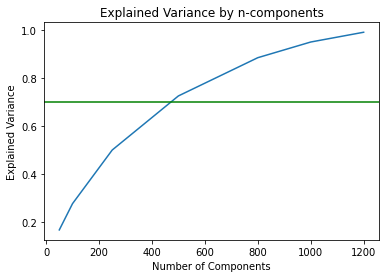

In [ ]:
lsa_doc = LSA(corpus, mat_tfidf)

--------------------------- Starting GloVe algorithm ---------------------------

------------------- Starting import of Co-Occurrence Matrix --------------------

----------------- Starting random initialization of parameters -----------------

----------------------------- Starting calculation -----------------------------



100%|██████████| 40/40 [00:57<00:00,  1.43s/it]


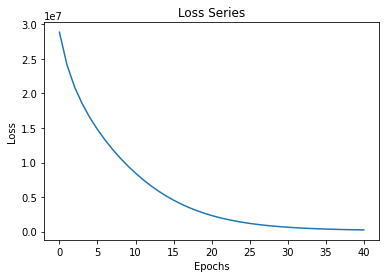

1286it [00:00, 1883.47it/s]


In [ ]:
context_matrix, target_matrix = GloVe(corpus, epochs=40, eta=0.0001, overwrite=False)
glove_doc = docPresentation_alt(corpus=corpus, embedding_matrix=context_matrix + target_matrix)

In [ ]:
w2v_embedding = w2v_matrix(corpus=corpus, window_size=5, min_count=1, sg=1, vector_size=300)
w2v_doc = docPresentation_alt(corpus=corpus, embedding_matrix=w2v_embedding)

1286it [00:12, 100.02it/s]


In [ ]:
# Data Prep
sample_method = "SMOTE"
nfolds = 10
encoding_matrix = generateEncodingMatrix(data['label_l1'])

tfidf_sample = dataSample(tfidf_doc, data, method=sample_method, n=0, folds=nfolds)
lsa_sample = dataSample(lsa_doc, data, method=sample_method, n=0, folds=nfolds)
glove_sample = dataSample(glove_doc, data, method=sample_method, n=0, folds=nfolds)
w2v_sample = dataSample(w2v_doc, data, method=sample_method, n=0, folds=nfolds)

# Sample Split:
convert_to_dic = lambda x: {l: i for l, i in zip(['dataTrain', 'dataTest'], x)}

tfidf_data = convert_to_dic(dataSplit(tfidf_sample))
lsa_data = convert_to_dic(dataSplit(lsa_sample))
glove_data = convert_to_dic(dataSplit(glove_sample))
w2v_data = convert_to_dic(dataSplit(w2v_sample))

Prior to the discussion of the results, the data has to be imported and the word embedding methods have to be fitted. Firstly the data is imported, checked and preprocessed via the functions ```DataImport()```, ```dataCheck()``` and ```textPreprocessing()```, which were discussed in the first chapters. In addition, the word embeddings tf-idf, LSA, GloVe and Word to Vec are calculated and saved in different data-frames and transformed into document presentations via the function ```docPresentation_alt()``` (please note that the suffix “_alt” stands for an alternative function for the original document presentation function implemented by the authors, but only the alternative is used). After the document presentations, which serve as input for the classifiers, are constructed the data has to be prepared for further processing. Additionally, the encoding matrix is constructed via ```generateEncodingMatrix()```. In order to counteract the effects of the unbalanced data, the data gets oversampled by the “SMOTE” method. This is done with the help of the ```dataSample()``` function, which has the document presentation, the label data as well as the sampling method as input parameters. The function additionally has the parameter ```folds```, which determines the number of folds which should be used and are utilized for cross validation, which is covered in the comparison chapter. Finally the data is splitted into test and train data, which are combined in a dictionary via the lambda function ```convert_to_dic()```.

In the following the results for the two classifiers are shown seperatly. Main focus is thereby on the in-sample fit, which is the reason why the whole dataset is used for each performance evaluation. This shows how well the models fit to the already known data and how well they can deal with the unbalanced data. Afterwards the out-of-sample performance differences between the classfiers are discussed. For that a cross-validation aproach was used in order to get an average picture of the out-of-sample error.

### Results of Linear-Classifier

In [ ]:
# Fit classifier
data_tfidf_lin = classifierLinear(tfidf_data['dataTrain'], tfidf_doc, data['label_l1'].copy())
data_lsa_lin = classifierLinear(lsa_data['dataTrain'], lsa_doc, data['label_l1'].copy())
data_glove_lin = classifierLinear(glove_data['dataTrain'], glove_doc, data['label_l1'].copy())
data_w2v_lin = classifierLinear(w2v_data['dataTrain'], w2v_doc, data['label_l1'].copy())

-------------------------- Starting Linear Classifier --------------------------

-------------------------- Starting Linear Classifier --------------------------

-------------------------- Starting Linear Classifier --------------------------

-------------------------- Starting Linear Classifier --------------------------



/opt/homebrew/Caskroom/miniforge/base/envs/DataSciPy_fast/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


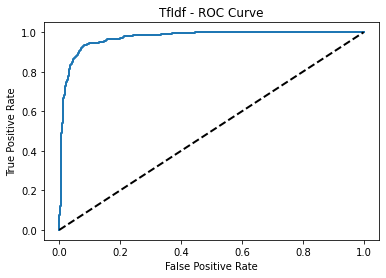

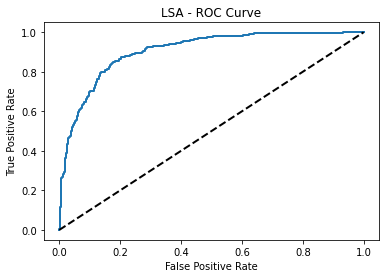

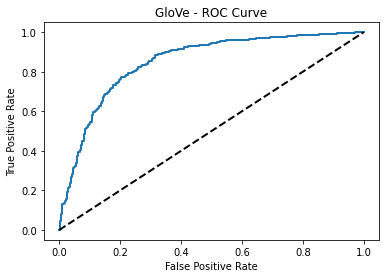

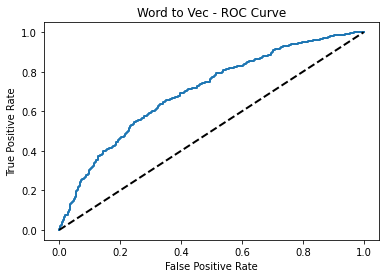

In [ ]:
# Performance Evaluation
conf_matrix_tfidf = calculateConfusionMatrix(data_tfidf_lin['label_l1'], data_tfidf_lin['label_l1_LINpred'])
auc_tfidf = roc_measure(data_tfidf_lin, encoding_matrix, label_true = 'label_l1', label_prob = 'label_l1_LINprob', plot_title = 'TfIdf - ROC Curve')

conf_matrix_lsa = calculateConfusionMatrix(data_lsa_lin['label_l1'], data_lsa_lin['label_l1_LINpred'])
auc_lsa = roc_measure(data_lsa_lin, encoding_matrix, label_true = 'label_l1', label_prob = 'label_l1_LINprob', plot_title = 'LSA - ROC Curve')

conf_matrix_glove = calculateConfusionMatrix(data_glove_lin['label_l1'], data_glove_lin['label_l1_LINpred'])
auc_glove = roc_measure(data_glove_lin, encoding_matrix, label_true = 'label_l1', label_prob = 'label_l1_LINprob', plot_title = 'GloVe - ROC Curve')

conf_matrix_w2v = calculateConfusionMatrix(data_w2v_lin['label_l1'], data_w2v_lin['label_l1_LINpred'])
auc_w2v = roc_measure(data_w2v_lin, encoding_matrix, label_true = 'label_l1', label_prob = 'label_l1_LINprob', plot_title = 'Word to Vec - ROC Curve')

AUC_res = pd.DataFrame([auc_tfidf, auc_lsa, auc_glove, auc_w2v], index = ['TfIdf', 'LSA', 'GloVe', 'W2V'], columns = ["AUC"])

In [ ]:
display_side_by_side([conf_matrix_tfidf, conf_matrix_lsa, conf_matrix_glove, conf_matrix_w2v], captions=['TfIdf', 'LSA', 'GloVe', 'W2V'])

,pred Question_1_Company_specific,pred Question_1_Market_related
Question_1_Company_specific,0.660964,0.044323
Question_1_Market_related,0.032659,0.262053
,pred Question_1_Company_specific,pred Question_1_Market_related
Question_1_Company_specific,0.590202,0.115086
Question_1_Market_related,0.052877,0.241835
,pred Question_1_Company_specific,pred Question_1_Market_related
Question_1_Company_specific,0.562208,0.143079
Question_1_Market_related,0.067652,0.227061
,pred Question_1_Company_specific,pred Question_1_Market_related
Question_1_Company_specific,0.479005,0.226283


In [ ]:
AUC_res

,AUC
TfIdf,0.971919
LSA,0.904760
GloVe,0.849947
W2V,0.701335


The results of the Linear-Classifier reveal a clear pattern from which emerges that tf-idf seems to be clearly the optimal word-embedding for this type of classification algorithm while the classifier can only barely exploit the information given by Word to Vec. However, LSA and GloVe line up in between with almost identical ROC curves. The tf-idf results do not only outperform the remaining word-embeddings but also allow for an increase in the tpr with only a small associated increase in fpr at an tpr approximately at 0.8. The ranking resulting from the ROC curves is also reflected in the confusion matrices and shows that the bad results of the Word to Vec embedding is originated in a high amount of false predicting the label “Question_1_Company_specific” as “Question_1_Market_related”.  LSA and GloVe show a similar behaviour but less pronounced. 

In summary it can be observed that all word-embeddings are able to serve as input for the linear (logit-) classifier, which can be also observed by the AUC results. In addition, the “simpler” word-embeddings outperform the Word to Vec and GloVe techniques.

### Results of Neural-Network-Classifier

Trial 5 Complete [00h 00m 00s]
val_loss: 0.6940966844558716

Best val_loss So Far: 0.6897057294845581
Total elapsed time: 00h 00m 03s
INFO:tensorflow:Oracle triggered exit
------------------------------ Fitting best model ------------------------------

Epoch 1/20
13/13 [==============================] - 0s 5ms/step - loss: 0.7006 - val_loss: 0.6914
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6936 - val_loss: 0.7036
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6947 - val_loss: 0.6952
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6967 - val_loss: 0.6952
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6949 - val_loss: 0.7004
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6987 - val_loss: 0.6951
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6973 - val_loss: 0.7125
Epoch 8/20
13/13 [==============================] - 0s 2ms/s

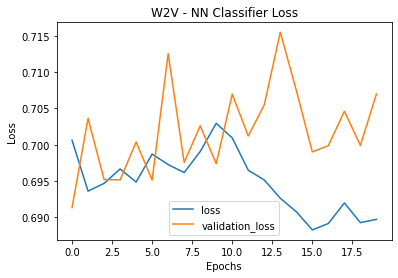

In [ ]:
# Fit classifier
data_tfidf_nn = classifierNN(tfidf_data['dataTrain'], tfidf_data['dataTest'], tfidf_doc, data['label_l1'].copy(), encoding_matrix, project_name="NN_tfidf", plot_title="TfIdf - NN Classifier Loss")
data_lsa_nn = classifierNN(lsa_data['dataTrain'], lsa_data['dataTest'], lsa_doc, data['label_l1'].copy(), encoding_matrix, project_name="NN_lsa", plot_title="LSA - NN Classifier Loss")
data_glove_nn = classifierNN(glove_data['dataTrain'], glove_data['dataTest'], glove_doc, data['label_l1'].copy(), encoding_matrix, project_name="NN_glove", plot_title="GloVe - NN Classifier Loss")
data_w2v_nn = classifierNN(w2v_data['dataTrain'], w2v_data['dataTest'], w2v_doc, data['label_l1'].copy(), encoding_matrix, project_name="NN_w2v", plot_title="W2V - NN Classifier Loss")

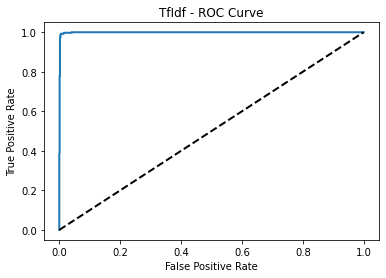

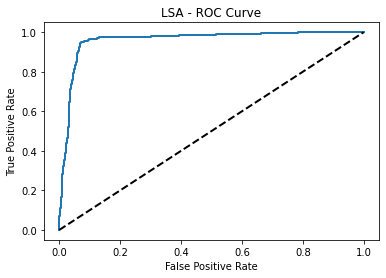

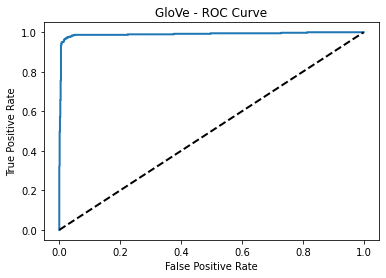

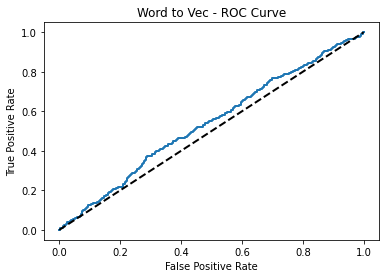

In [ ]:
# Performance Evaluation
conf_matrix_tfidf = calculateConfusionMatrix(data_tfidf_nn['label_l1'], data_tfidf_nn['label_l1_NNpred'])
auc_tfidf = roc_measure(data_tfidf_nn, encoding_matrix, label_true = 'label_l1', label_prob = 'label_l1_NNprob', plot_title = 'TfIdf - ROC Curve')

conf_matrix_lsa = calculateConfusionMatrix(data_lsa_nn['label_l1'], data_lsa_nn['label_l1_NNpred'])
auc_lsa = roc_measure(data_lsa_nn, encoding_matrix, label_true = 'label_l1', label_prob = 'label_l1_NNprob', plot_title = 'LSA - ROC Curve')

conf_matrix_glove = calculateConfusionMatrix(data_glove_nn['label_l1'], data_glove_nn['label_l1_NNpred'])
auc_glove = roc_measure(data_glove_nn, encoding_matrix, label_true = 'label_l1', label_prob = 'label_l1_NNprob', plot_title = 'GloVe - ROC Curve')

conf_matrix_w2v = calculateConfusionMatrix(data_w2v_nn['label_l1'], data_w2v_nn['label_l1_NNpred'])
auc_w2v = roc_measure(data_w2v_nn, encoding_matrix, label_true = 'label_l1', label_prob = 'label_l1_NNprob', plot_title = 'Word to Vec - ROC Curve')

AUC_res = pd.DataFrame([auc_tfidf, auc_lsa, auc_glove, auc_w2v], index = ['TfIdf', 'LSA', 'GloVe', 'W2V'], columns = ["AUC"])

In [ ]:
display_side_by_side([conf_matrix_tfidf, conf_matrix_lsa, conf_matrix_glove, conf_matrix_w2v], captions=['TfIdf', 'LSA', 'GloVe', 'W2V'])

,pred Question_1_Company_specific,pred Question_1_Market_related
Question_1_Company_specific,0.690513,0.014774
Question_1_Market_related,0.000778,0.293935
,pred Question_1_Company_specific,pred Question_1_Market_related
Question_1_Company_specific,0.654743,0.050544
Question_1_Market_related,0.014774,0.279938
,pred Question_1_Company_specific,pred Question_1_Market_related
Question_1_Company_specific,0.690513,0.014774
Question_1_Market_related,0.009331,0.285381
,pred Question_1_Company_specific,pred Question_1_Market_related
Question_1_Company_specific,0.056765,0.648523


In [ ]:
AUC_res

,AUC
TfIdf,0.998881
LSA,0.959433
GloVe,0.989913
W2V,0.537985


Similar as to the Linear-Classifier the textual representation tf-idf seems to be the most valuable input for this classification problem, with a almost perfect ROC curve. This indicates that the Neural-Network-Classifier in combination with the tf-idf word representation is able to almost predict every label correctly except a minor percentage, which can be seen in the associated confusion matrix. Surprisingly again the word embeddings GloVe and Word to Vec are not able to outperform the tf-idf technique. One reason for this might be because the method does not transform the words in any kind but rather is simply based on frequency, i. e. no information loss due to approximation. Therefore, it can be derived that contextual informations, e. g. taken into account by GloVe, is equally important for the classification of the underlying earning calls as the token frequency. However, GloVe and LSA show also good results but suffer in the sense of wrongly specifying the label "Question_1_Market_related" as "Question_1_Company_specific". The three methods also share the behaviour of a very steep ROC curve which indicates a very robust classification. However, GloVe and LSA are only able to predict all "Question_1_Company_specific" labels correctly by increasing the false positive rate. This can be seen at the rounded corners of the associated ROC curves.

Regarding Word to Vec, the technique seems again to be outperformed by all other methods and is barely able to outperform a random classifier. The results are even worse as in combination with the Linear-Classifier. The difference between the results of GloVe and Word to Vec is again very high and suggests that contextual and frequency-based measures are more important for the right classification as a numerical representation given a word to predict the context, since skip-gram is used. This also indicates that directly taking the context into account, rather than predicting it, is more valuable at least in this classification problem.
The AUC measures unsurprisingly suggest that the tf-idf and GloVe techniques are able to outperform the remaining methods.

The analysis of the in-sample performance shows, that both models can indeed capture the systematic relationsip between the word embedding and the label-groups. Therefore the next step is to analyse the prediction performance via the out-of-sample performance.


### Comparison of Linear- and Neural-Network-Classifier

Trial 5 Complete [00h 00m 00s]
val_loss: 0.702132523059845

Best val_loss So Far: 0.6862784028053284
Total elapsed time: 00h 00m 04s
INFO:tensorflow:Oracle triggered exit
------------------------------ Fitting best model ------------------------------

Epoch 1/20
13/13 [==============================] - 0s 5ms/step - loss: 0.6934 - val_loss: 0.6966
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6946 - val_loss: 0.6981
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6953 - val_loss: 0.7070
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 0.7082 - val_loss: 0.7121
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 0.6996 - val_loss: 0.6860
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 0.7089 - val_loss: 0.6867
Epoch 7/20
13/13 [==============================] - 0s 2ms/step - loss: 0.7046 - val_loss: 0.6926
Epoch 8/20
13/13 [==============================] - 0s 2ms/st

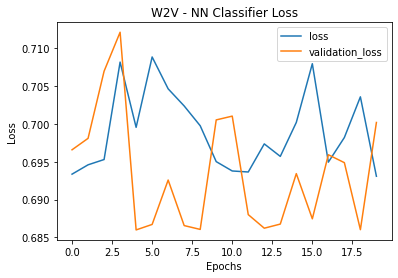

100%|██████████| 10/10 [04:06<00:00, 24.62s/it]


In [ ]:
resultMatrix = pd.DataFrame(0, columns=['TfIdf', 'LSA', 'GloVe', 'Word to Vec'], index = ['Linear-Classifier', 'Neural-Network-Classifier'])
prompt("Starting Cross-Validation")
for i in tqdm(range(1, nfolds+1)):
    # Sample Split:
    tfidf_data = convert_to_dic(dataSplit(tfidf_sample, test_fold=i))
    lsa_data = convert_to_dic(dataSplit(lsa_sample, test_fold=i))
    glove_data = convert_to_dic(dataSplit(glove_sample, test_fold=i))
    w2v_data = convert_to_dic(dataSplit(w2v_sample, test_fold=i))

    # Linear Classifier
    # Fit classifier
    data_tfidf_lin = classifierLinear(tfidf_data['dataTrain'], tfidf_data['dataTest']['doc'], tfidf_data['dataTest']['labels'])
    data_lsa_lin = classifierLinear(lsa_data['dataTrain'], lsa_data['dataTest']['doc'], lsa_data['dataTest']['labels'])
    data_glove_lin = classifierLinear(glove_data['dataTrain'], glove_data['dataTest']['doc'], glove_data['dataTest']['labels'])
    data_w2v_lin = classifierLinear(w2v_data['dataTrain'], w2v_data['dataTest']['doc'], w2v_data['dataTest']['labels'])

    # Performance Eval
    resultMatrix.loc['Linear-Classifier', 'TfIdf'] += roc_measure(data_tfidf_lin, encoding_matrix, label_true='label_l1', label_prob='label_l1_LINprob',
                            plot_title='TfIdf - ROC Curve', plot=False)
    resultMatrix.loc['Linear-Classifier', 'LSA'] += roc_measure(data_lsa_lin, encoding_matrix, label_true='label_l1', label_prob='label_l1_LINprob',
                          plot_title='LSA - ROC Curve', plot=False)
    resultMatrix.loc['Linear-Classifier', 'GloVe'] += roc_measure(data_glove_lin, encoding_matrix, label_true='label_l1', label_prob='label_l1_LINprob',
                            plot_title='GloVe - ROC Curve', plot=False)
    resultMatrix.loc['Linear-Classifier', 'Word to Vec'] += roc_measure(data_w2v_lin, encoding_matrix, label_true='label_l1', label_prob='label_l1_LINprob',
                          plot_title='Word to Vec - ROC Curve', plot=False)

    # NN Classifier
    # Fit classifier
    data_tfidf_nn = classifierNN(tfidf_data['dataTrain'], tfidf_data['dataTest'], tfidf_data['dataTest']['doc'], tfidf_data['dataTest']['labels'], encoding_matrix,
                                 project_name="NN_tfidf", plot_title="TfIdf - NN Classifier Loss")
    data_lsa_nn = classifierNN(lsa_data['dataTrain'], lsa_data['dataTest'], lsa_data['dataTest']['doc'], lsa_data['dataTest']['labels'], encoding_matrix,
                               project_name="NN_lsa", plot_title="LSA - NN Classifier Loss")
    data_glove_nn = classifierNN(glove_data['dataTrain'], glove_data['dataTest'], glove_data['dataTest']['doc'], glove_data['dataTest']['labels'], encoding_matrix,
                                 project_name="NN_glove", plot_title="GloVe - NN Classifier Loss")
    data_w2v_nn = classifierNN(w2v_data['dataTrain'], w2v_data['dataTest'], w2v_data['dataTest']['doc'], w2v_data['dataTest']['labels'], encoding_matrix,
                               project_name="NN_w2v", plot_title="W2V - NN Classifier Loss")

    # Performance Eval
    resultMatrix.loc['Neural-Network-Classifier', 'TfIdf'] += roc_measure(data_tfidf_nn, encoding_matrix, label_true='label_l1', label_prob='label_l1_NNprob',
                            plot_title='TfIdf - ROC Curve', plot=False)
    resultMatrix.loc['Neural-Network-Classifier', 'LSA'] += roc_measure(data_lsa_nn, encoding_matrix, label_true='label_l1', label_prob='label_l1_NNprob',
                          plot_title='LSA - ROC Curve', plot=False)
    resultMatrix.loc['Neural-Network-Classifier', 'GloVe'] += roc_measure(data_glove_nn, encoding_matrix, label_true='label_l1', label_prob='label_l1_NNprob',
                            plot_title='GloVe - ROC Curve', plot=False)
    resultMatrix.loc['Neural-Network-Classifier', 'Word to Vec'] += roc_measure(data_w2v_nn, encoding_matrix, label_true='label_l1', label_prob='label_l1_NNprob',
                          plot_title='Word to Vec - ROC Curve', plot=False)

resultMatrix = resultMatrix / nfolds

In [ ]:
resultMatrix

,TfIdf,LSA,GloVe,Word to Vec
Linear-Classifier,0.900121,0.842218,0.735709,0.686488
Neural-Network-Classifier,0.964499,0.875349,0.905495,0.560655


These results show a cross-validation based evaluation to validate the differences in the average performance of the four word embeddings in combination with both classifiers (linear and neural-network based). This is obtained by splitting the dataset into 10 equally sized folds via the function ```dataSplit()```. Then nine folds are used for training and one fold is used for testing the performance of the word representation - classifier combination. The results, represented by the AUC across all folds is then averaged by dividing the sum of the AUC per word representation - classifier combination by the number of folds, which is ten. 

Regarding tf-idf and LSA the results are similar with a small outperformance regarding the Neural-Network-Classifier. By looking at the results for GloVe and Word to Vec it is interesting to see that on average, the Linear Classifier works better with the Word to Vec method while the Neural-Network-Classifier is able to exploit the information more efficiently given by GloVe. Overall, the Neural-Network-Classifier is able to outperform the Linear-Classifier on average for almost all word embeddings except Word to Vec. Additionally, it can be derived that the word embedding technique is more important for the Neural-Network-Classifer as for the Linear-Classifier by calculating the range of the results:

$Result Range_{classifier} = max(results) - min(results)$

Since the Neural-Network-Classifier has a higher range in the results, even though the results are better, different word embeddings should be taken into account when using this classifier.


## Conclusion

In this notebook we provided evaluations on four different word embedding techniques by passing the results into two different classifiers, measured by three different performance evaluation methods. The results show that different type of word embeddings have sometimes more and sometimes less relevance for the classification results. While the results for tf-idf and LSA are comparably good for both classifiers the results differ for the more complex word embedding techniques GloVe and Word to Vec. Further the diversity of the results suggests that there are many factors affecting the quality of the word-embedding and the optimal word-embedding for different classifiers. By applying a Neural-Network-Classifier we were able to demonstrate that the results can be improved by combining the word embeddings with more complex classification models. Nevertheless, it is impressive to see that the Linear-Classifier is only barely outperformed by the Neural-Network-Classifier. In conclusion it could be derived that different word embeddings work differently well. In addition, this might be also the case for different types of classification problems. Therefore, different word embeddings - classification combinations should be used.